# Загрузка необходимых библиотек и данных

In [58]:
# загружаем библиотеки
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [60]:
#загружаем данные, с которыми будем работать
dfr = pd.read_csv('rosnavyk.csv')
dfh = pd.read_csv('cleared.csv')

# Изменение данных для более удобной работы

In [63]:
# Проверка размера исходных данных
print(f"Размер исходных данных из РосНавык: {dfr.shape}")
print(f"Размер исходных данных из очищенного набора: {dfh.shape}")

Размер исходных данных из РосНавык: (700, 4)
Размер исходных данных из очищенного набора: (1232, 6)


In [65]:
# переименование колонок для удобства работы и будущего объединения
new_columns = {
    "Опыт работы": "experience",
    "График работы": "employment",
    "Заработная плата": "salary",
    "Название региона": "area"
}

In [67]:
dfr = dfr.rename(columns = new_columns)

In [69]:
# преобразование опыта к более приятному виду
dfr['experience'] = dfr['experience'].replace({
    '0': 0,
    '1-3': 1,
    '3-6': 2,
    '6-': 3
})

In [71]:
# преобразование графика работы к числовым значениям
dfr['employment'] = dfr['employment'].replace({
    'Полный день': 0,
    'Гибкий график': 1,
    'Удаленная работа': 5
})

In [73]:
# разделение значения зарплаты в dfr на минимальную и максимальную
dfr['salary_min'] = dfr['salary']
dfr['salary_max'] = dfr['salary']
dfr = dfr.drop('salary', axis=1)

In [75]:
# объединение двух наборов данных
df = pd.concat([dfr, dfh])

# сброс индекса
df = df.reset_index(drop=True)

In [77]:
# приведение таблицы area к нижнему регистру
df['area'] = df['area'].str.lower()

In [79]:
# удаление неинформативных колонок
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

In [81]:
# замена нулевых значений в зарплате на средние по медиане
median_min = df['salary_min'].replace(0, np.nan).median(skipna=True)
median_max = df['salary_max'].replace(0, np.nan).median(skipna=True)
df['salary_min'] = df['salary_min'].replace(0, median_min)
df['salary_max'] = df['salary_max'].replace(0, median_max)

In [83]:
# для каждого атрибута добавляем текстовое описание
attribute_descriptions = {
    'experience': 'Опыт работы в годах',
    'employment': 'График работы (0 - полный день, 1 - гибкий график, 5 - удаленная работа)',
    'salary_min': 'Минимальная заработная плата',
    'salary_max': 'Максимальная заработная плата',
    'area': 'Регион работы',
    'published_date': 'Дата публикации вакансии'
}
# выводим текстовое описание
print("Описание атрибутов:\n", attribute_descriptions)

Описание атрибутов:
 {'experience': 'Опыт работы в годах', 'employment': 'График работы (0 - полный день, 1 - гибкий график, 5 - удаленная работа)', 'salary_min': 'Минимальная заработная плата', 'salary_max': 'Максимальная заработная плата', 'area': 'Регион работы', 'published_date': 'Дата публикации вакансии'}


In [85]:
df

,area,employment,experience,salary_min,salary_max
0,москва,0,2,100000,120000
1,москва,0,2,100000,120000
2,москва,5,1,100000,120000
3,москва,0,1,100000,120000
4,москва,5,1,180000,180000
...,...,...,...,...,...
1927,санкт-петербург,0,1,150000,200000
1928,москва,0,2,150000,200000
1929,тольятти,4,0,100000,110000
1930,красноярск,0,1,80000,130000


# Обработка данных и статистический анализ

In [88]:
# анализ пропущенных данных
missing_data = df.isnull().sum()
print("Пропущенные данные по колонкам:\n", missing_data)

Пропущенные данные по колонкам:
 area          0
employment    0
experience    0
salary_min    0
salary_max    0
dtype: int64


In [90]:
# оценка критических значений пропущенных данных
critical_threshold = 0.1  # 10% пропусков считаем критическим значением
for col in df.columns:
    missing_rate = missing_data[col] / len(df)
    if missing_rate > critical_threshold:
        print(f"Критическое количество пропусков в колонке {col}: {missing_rate:.2%}")

In [92]:
# информация о количестве пустых значений для каждого атрибута
for col in df.columns:
    print(f"{col}: {df[col].isnull().sum()} пропущенных значений")

area: 0 пропущенных значений
employment: 0 пропущенных значений
experience: 0 пропущенных значений
salary_min: 0 пропущенных значений
salary_max: 0 пропущенных значений


In [94]:
numerical_columns = ['experience', 'employment', 'salary_min', 'salary_max']

In [96]:
# оценка погрешности
original_means = df[numerical_columns].mean(skipna=True) # Средние значения до импутации

imputer = SimpleImputer(strategy='median')  #  Можно использовать другую стратегию
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

imputed_means = df[numerical_columns].mean() # Средние значения после импутации

error = (imputed_means - original_means) / original_means * 100 # Погрешность в процентах

print(f"Погрешность после импутации (в %):\n{error}")

Погрешность после импутации (в %):
experience    0.0
employment    0.0
salary_min    0.0
salary_max    0.0
dtype: float64


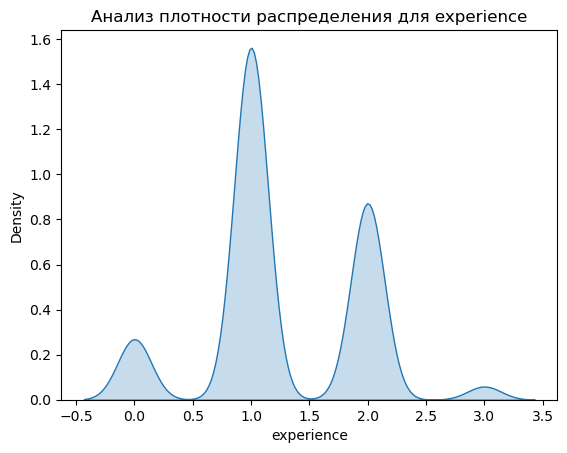

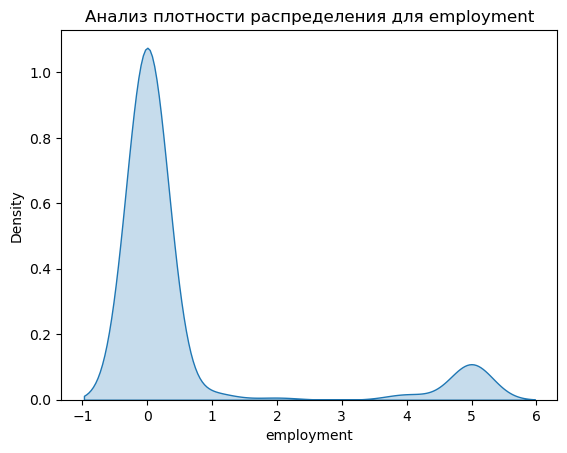

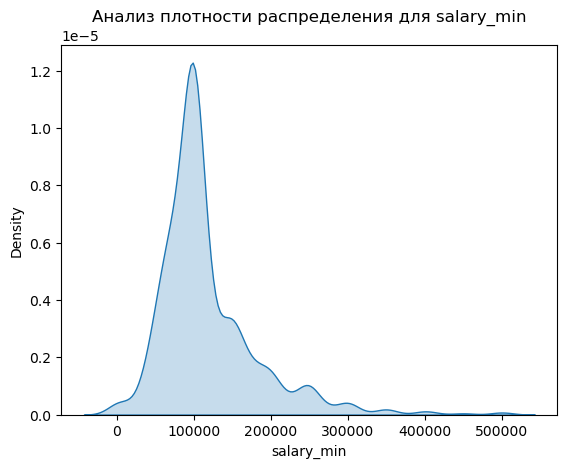

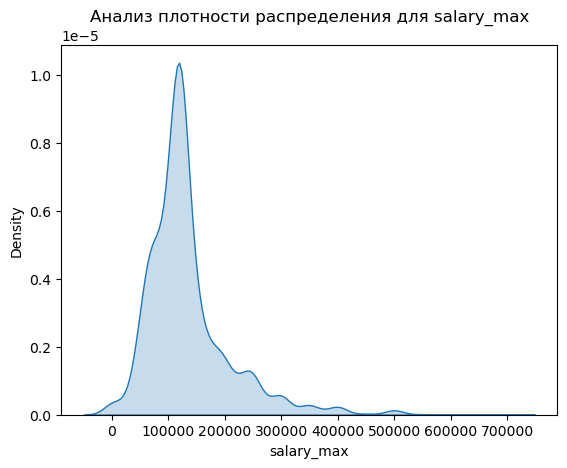

In [98]:
# анализ плотности распределения для каждого числового атрибута
for col in numerical_columns:
    sns.kdeplot(df[col], shade=True)
    plt.title(f"Анализ плотности распределения для {col}")
    plt.show()

In [99]:
for col in numerical_columns:
    stat, p = stats.shapiro(df[col].dropna())
    print(f"Тест Шапиро-Уилка для {col}: p-value = {p}")
    if p > 0.05:
        print(f"Распределение {col} нормальное")
    else:
        print(f"Распределение {col} не является нормальным")

Тест Шапиро-Уилка для experience: p-value = 2.3050255109905087e-43
Распределение experience не является нормальным
Тест Шапиро-Уилка для employment: p-value = 4.7081539832395215e-63
Распределение employment не является нормальным
Тест Шапиро-Уилка для salary_min: p-value = 5.042283303606273e-42
Распределение salary_min не является нормальным
Тест Шапиро-Уилка для salary_max: p-value = 1.5878756193944897e-41
Распределение salary_max не является нормальным


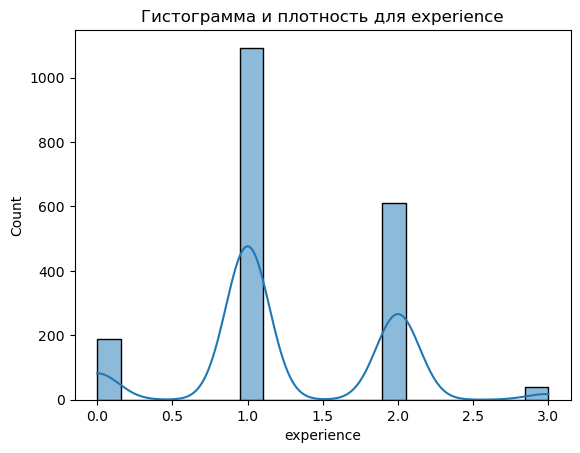

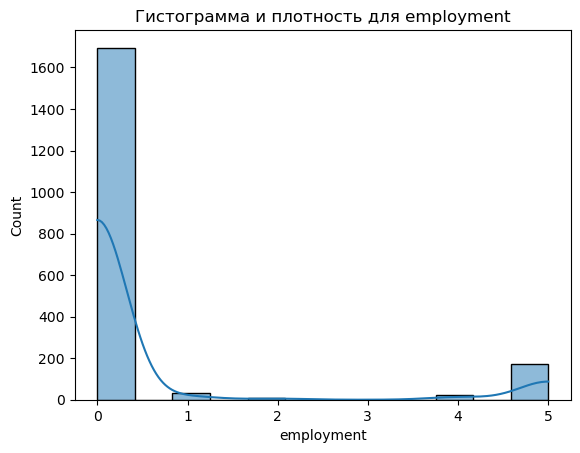

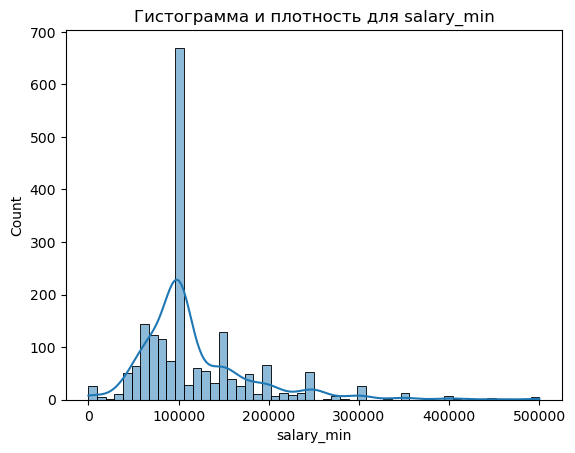

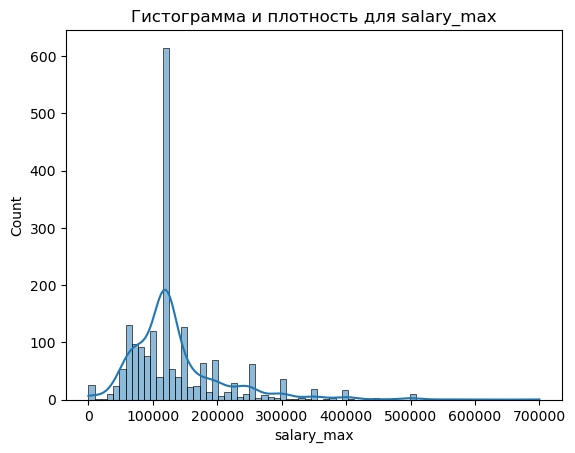

In [100]:
# графическая и статистическая оценка распределений
for col in numerical_columns:
    sns.histplot(df[col], kde=True)
    plt.title(f"Гистограмма и плотность для {col}")
    plt.show()

In [104]:
original_means = df[numerical_columns].mean(skipna=True) # Средние значения до импутации

imputer = SimpleImputer(strategy='median')  #  Можно использовать другую стратегию
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

imputed_means = df[numerical_columns].mean() # Средние значения после импутации

error = (imputed_means - original_means) / original_means * 100 # Погрешность в процентах

print(f"Погрешность после импутации (в %):\n{error}")

Погрешность после импутации (в %):
experience    0.0
employment    0.0
salary_min    0.0
salary_max    0.0
dtype: float64


In [106]:
df_dum = pd.get_dummies(df, columns=['area'])

In [108]:
df_dum = pd.get_dummies(df, columns=['area']) 
columns_for_cor = [
    "salary_min",
    "salary_max",
    "area_москва",
    "area_санкт-петербург",
    "area_московская область",
    "area_нижегородская область",
    "area_республика татарстан",
    "area_свердловская область",
    "area_краснодарский край",
    "area_новосибирская область",
]

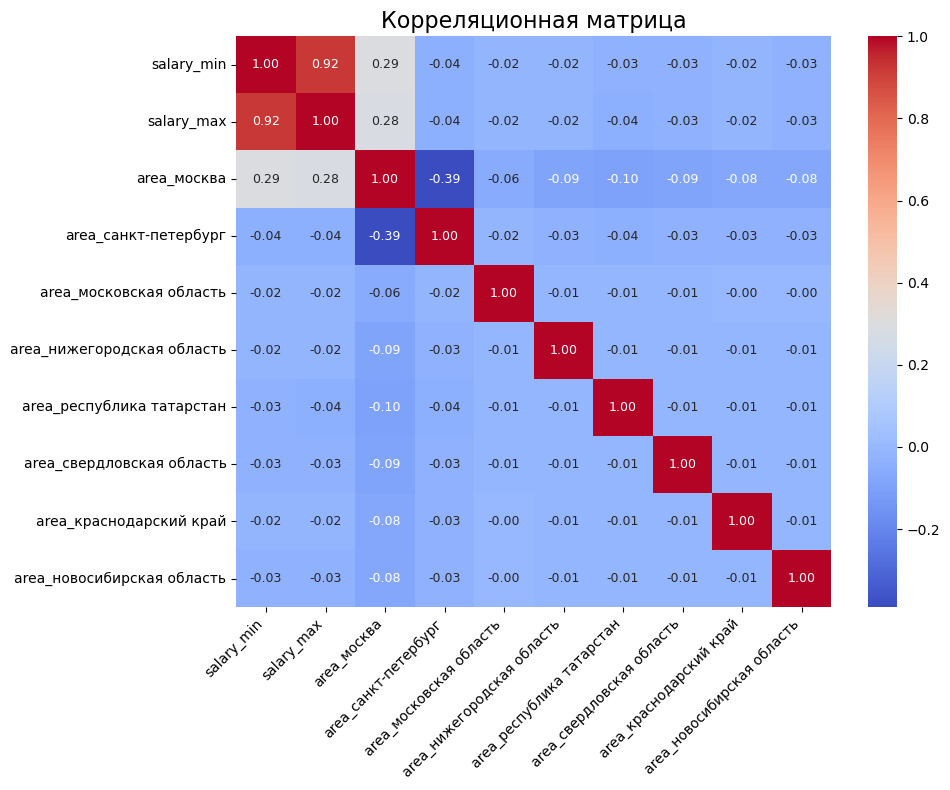

In [110]:
plt.figure(figsize=(10, 8))
corr_matrix = df_dum[columns_for_cor].corr().round(2)
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 9}, fmt=".2f", cmap="coolwarm") #  cmap для цветовой схемы
plt.title("Корреляционная матрица", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Поворот подписей по оси x
plt.yticks(rotation=0) #  Вертикальные подписи по оси y
plt.tight_layout() #  Оптимизация расположения элементов
plt.show()

In [112]:
df.to_csv('preprocessed_data.csv', index=False)

# Значимость атрибутов

experience (Опыт работы): Опыт работы является важным фактором, влияющим на уровень заработной платы и требования к кандидату. Анализ этого атрибута позволит выявить зависимость между опытом и зарплатой, а также определить, какой опыт работы наиболее востребован на рынке труда.

employment (График работы): Различные графики работы (полный день, гибкий график, удаленная работа) могут привлекать разные категории соискателей и предлагаться для разных типов вакансий. Анализ этого атрибута поможет определить распространенность различных графиков работы и их связь с другими факторами, такими как зарплата и регион.

salary_min (Минимальная заработная плата) и salary_max (Максимальная заработная плата): Зарплата является одним из ключевых факторов при выборе работы. Анализ этих атрибутов позволит определить диапазоны зарплат для различных вакансий, выявить зависимость зарплаты от опыта работы, графика работы и региона.

area (Регион работы): Уровень зарплат и востребованность специалистов могут значительно различаться в зависимости от региона. Анализ этого атрибута поможет выявить регионы с наиболее высокими и низкими зарплатами, а также определить, в каких регионах наиболее востребованы специалисты определенного профиля.